# Sprite Attitude and Orbital Dynamics

#### V. Hunter Adams (vha3@cornell.edu)

In [1]:
from IPython.display import Latex
import matplotlib.pyplot as plt
# %matplotlib inline
import numpy
import numpy.linalg
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D
import random
from numpy.linalg import pinv
from scipy import interpolate
from IPython.display import Image
from IPython.core.display import HTML 
from IPython.display import HTML

The orbital dynamics model for the Sprites includes first and second-order gravitational terms and atmospheric drag. Higher-order geopotential terms and third-body perturbations are neglected because they are negligibly small in comparison to the dominant terms and perturbations. Justification for this is shown in Fig. 1, from Atchinson's thesis.

## Assumptions

1. The magnetic field is static, always pointing North (to be improved later)
2. The antennae can be modeled as a Kane Damper
3. Higher-than-J2 gravitational terms are negligible
4. Third-body gravitational perturbations are negligible
5. Drag is the dominant source of external force/torque

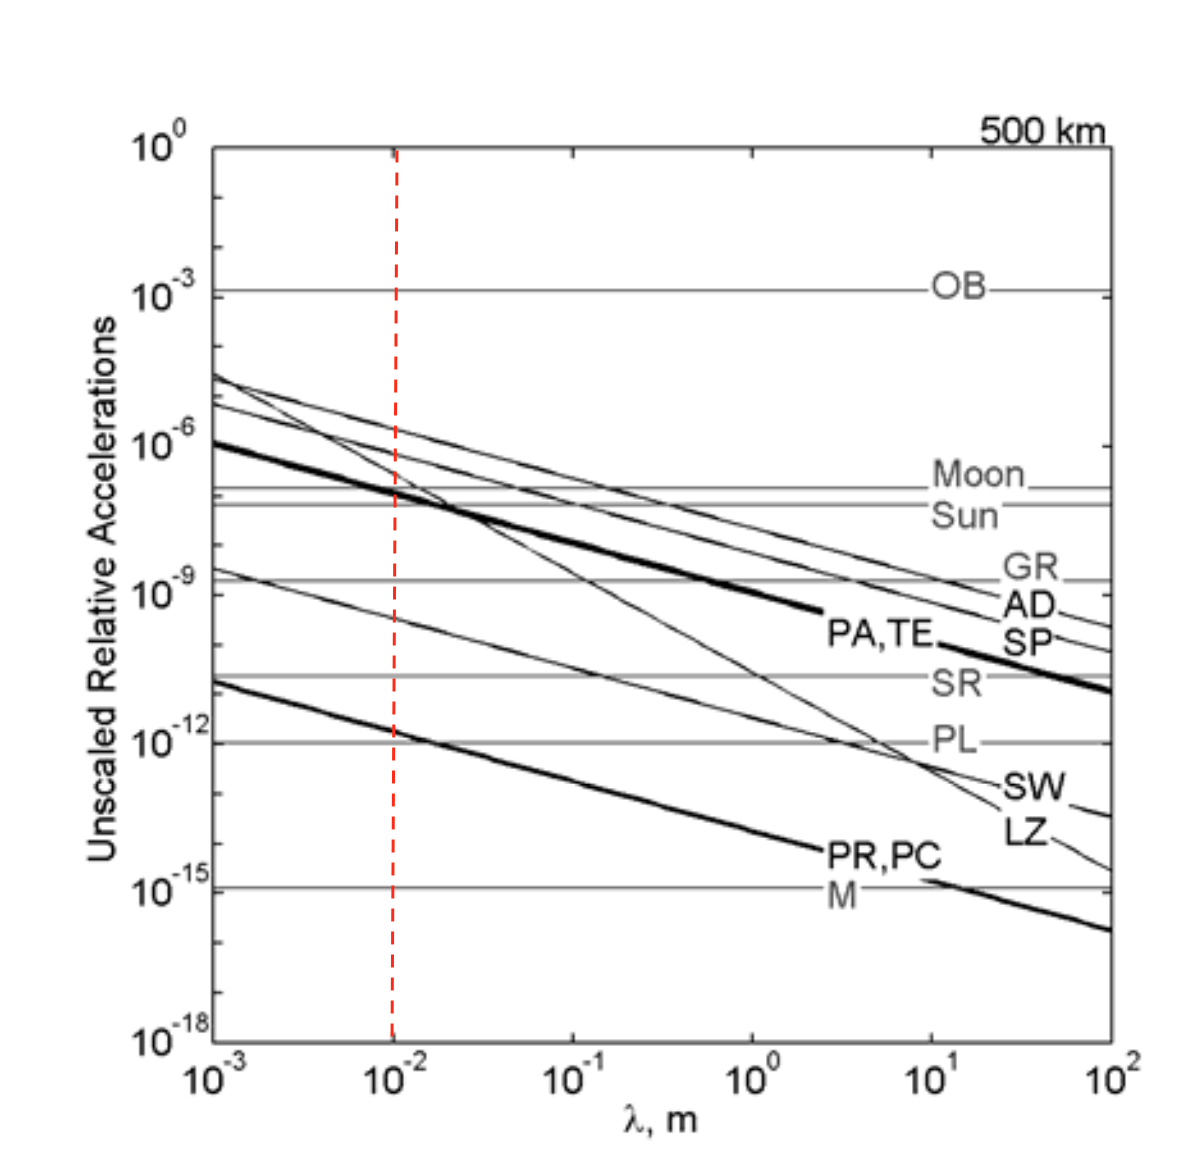

In [2]:
PATH = "/Users/hunteradams/Documents/PhD Semester 4/Swarms/Final Project/"
Image(filename = PATH + "accels.png", width=400, height=400)

Perturbing accelerations with spacecraft mass, at 500 km. Shows that earth oblateness is the dominant effect, followed by atmospheric drag (which is approximately an order of magnitude more significant than solar pressure at 500 km). The chipsats are operating below 400 km, which means atmospheric drag will be a few orders of magnitude more dominant. (Justin Atchinson's thesis)

## Orbital Dynamics

### Theory

The Lagrangian for the spacecraft is formed by subtracting the potential from the kinetic energy:

\begin{align}
\mathcal{L} &= T-V
\end{align}

#### Kinetic Energy

We will operate in an Earth-Centered Inertial coordinate frame. This places the origin on the center of the Earth, and lets the Earth rotate on top of the static coordinate system. In this coordinate system, the kinetic energy of the spacecraft is given simply by:

\begin{align}
T &= \frac{1}{2}m\dot{\underline{r}}^{2}
\end{align}

where $\underline{\dot{r}}$ is the time derivative of the position of the spacecraft. In an ECI coordinate frame, the position of the spacecraft is given by:

\begin{align}
\underline{r} &= x\hat{i} + y\hat{j} + z\hat{k}
\end{align}

Taking the time derivative:

\begin{align}
\underline{\dot{r}} &= \dot{x}\hat{i} + \dot{y}\hat{j} + \dot{z}\hat{k}\\
&= \begin{bmatrix}
\dot{x}\\\dot{y}\\\dot{z}
\end{bmatrix}
\end{align}

This gives a kinetic energy expression:

\begin{align}
T &= \frac{1}{2}m\underline{\dot{r}}^T\underline{\dot{r}}\\
&= \frac{1}{2}m\left[\dot{x}^2 + \dot{y}^2 + \dot{z}^2\right]
\end{align}

#### Potential Energy

The first two terms of the gravitational potential expression:

\begin{align}
V &= -\frac{G M_{E}m}{||\underline{r}||} + \frac{J_2m}{2||\underline{r}||^5}(3z^2 - ||\underline{r}||^2)
\end{align}

The first term is the point-mass gravitational term (dominant), the second is the J2 term associated with Earth's equatorial oblateness. This terms causes nodal precession of the Sprite orbits. Rewriting in terms of the state variables:

\begin{align}
V &= -\frac{G M_{E}m}{\left(x^2 + y^2 + z^2\right)^\frac{1}{2}} + \frac{J_2m}{2\left(x^2+y^2+z^2\right)^{\frac{5}{2}}} \left(3z^2 - \left(x^2+y^2+z^2\right)\right)
\end{align}

#### Assemble Lagrangian

Putting the kinetic and potential energy together:

\begin{align}
\mathcal{L} &= T - V\\
&= \frac{1}{2}m\left[\dot{x}^2 + \dot{y}^2 + \dot{z}^2\right]+\frac{G M_{E}m}{\left(x^2 + y^2 + z^2\right)^\frac{1}{2}} - \frac{J_2m}{2\left(x^2+y^2+z^2\right)^{\frac{5}{2}}} \left(3z^2 - \left(x^2+y^2+z^2\right)\right)
\end{align}

#### Euler-Lagrange Equation

In order to find the equation of motion for each state variable ($x$, $y$, $z$), we solve the Euler-Lagrange Equation:

\begin{align}
\frac{\partial{\mathcal{L}}}{\partial{q_i}} - \frac{d}{dt}\frac{\partial{\mathcal{L}}}{\partial{\dot{q_i}}} &= Q_{i}
\end{align}

Since, for now, we are assuming no external forces, $Q_i = 0$. $q_i$ is the $i^{th}$ state variable. Solving:

\begin{align}
\frac{d}{dt}\frac{\partial{\mathcal{L}}}{\partial{\dot{x}}} &= m\ddot{x}\\
\frac{\partial{\mathcal{L}}}{\partial{x}} &= -\frac{G m M_e x}{\left(x^2+y^2+z^2\right)^{3/2}}+\frac{5 J_2 m x \left(-x^2-y^2+2 z^2\right)}{2 \left(x^2+y^2+z^2\right)^{7/2}}+\frac{J_2 m x}{\left(x^2+y^2+z^2\right)^{5/2}}
\end{align}

Thus, the equation of motion for the $x$ state variable is given by:

\begin{align}
0 &= -\frac{G m M_e x}{\left(x^2+y^2+z^2\right)^{3/2}}+\frac{5 J_2 m x \left(-x^2-y^2+2 z^2\right)}{2 \left(x^2+y^2+z^2\right)^{7/2}}+\frac{J_2 m x}{\left(x^2+y^2+z^2\right)^{5/2}} - m\ddot{x}\\
\ddot{x} &=  -\frac{G M_e x}{\left(x^2+y^2+z^2\right)^{3/2}} + \frac{5 J_2 x \left(-x^2-y^2+2 z^2\right)}{2 \left(x^2+y^2+z^2\right)^{7/2}} + \frac{J_2 x}{\left(x^2+y^2+z^2\right)^{5/2}}
\end{align}

Similarly for $y$:

\begin{align}
\frac{d}{dt}\frac{\partial{\mathcal{L}}}{\partial{\dot{y}}} &= m\ddot{y}\\
\frac{\partial{\mathcal{L}}}{\partial{y}} &= -\frac{G m M_e y}{\left(x^2+y^2+z^2\right)^{3/2}}+\frac{5 J_2 m y \left(-x^2-y^2+2 z^2\right)}{2 \left(x^2+y^2+z^2\right)^{7/2}}+\frac{J_2 m y}{\left(x^2+y^2+z^2\right)^{5/2}}
\end{align}

Thus, the equation of motion for $y$:

\begin{align}
0 &= -\frac{G m M_e y}{\left(x^2+y^2+z^2\right)^{3/2}}+\frac{5 J_2 m y \left(-x^2-y^2+2 z^2\right)}{2 \left(x^2+y^2+z^2\right)^{7/2}}+\frac{J_2 m y}{\left(x^2+y^2+z^2\right)^{5/2}} - m\ddot{y}\\
\ddot{y} &= -\frac{G M_e y}{\left(x^2+y^2+z^2\right)^{3/2}}+\frac{5 J_2 y \left(-x^2-y^2+2 z^2\right)}{2 \left(x^2+y^2+z^2\right)^{7/2}}+\frac{J_2 y}{\left(x^2+y^2+z^2\right)^{5/2}}
\end{align}

And finally for $z$:

\begin{align}
\frac{d}{dt}\frac{\partial{\mathcal{L}}}{\partial{\dot{z}}} &= m\ddot{z}\\
\frac{\partial{\mathcal{L}}}{\partial{z}} &= -\frac{G m M_e z}{\left(x^2+y^2+z^2\right)^{3/2}}+\frac{5 J_2 m z \left(-x^2-y^2+2 z^2\right)}{2 \left(x^2+y^2+z^2\right)^{7/2}}-\frac{2 J_2 m z}{\left(x^2+y^2+z^2\right)^{5/2}}
\end{align}

Giving the equation of motion:

\begin{align}
0 &= -\frac{G m M_e z}{\left(x^2+y^2+z^2\right)^{3/2}}+\frac{5 J_2 m z \left(-x^2-y^2+2 z^2\right)}{2 \left(x^2+y^2+z^2\right)^{7/2}}-\frac{2 J_2 m z}{\left(x^2+y^2+z^2\right)^{5/2}} - m\ddot{z}\\
\ddot{z} &= -\frac{G  M_e z}{\left(x^2+y^2+z^2\right)^{3/2}}+\frac{5 J_2  z \left(-x^2-y^2+2 z^2\right)}{2 \left(x^2+y^2+z^2\right)^{7/2}}-\frac{2 J_2  z}{\left(x^2+y^2+z^2\right)^{5/2}}
\end{align}

#### State-Space Representation

Represent the differential equations of motion in state space:

\begin{align}
q_1 = x && \dot{q}_{1}=\dot{x}&=q_4\\
q_2 = y && \dot{q}_2 = \dot{y}&=q_5\\
q_3 = z && \dot{q}_3 = \dot{z}&=q_6\\
q_4 = \dot{x} && \dot{q}_{4} = \ddot{x} &= -\frac{\mu_E q_1}{\left(q_1^2+q_2^2+q_3^2\right)^{3/2}} + \frac{5 J_2 q_1 \left(-q_1^2-q_2^2+2 q_3^2\right)}{2 \left(q_1^2+q_2^2+q_3^2\right)^{7/2}} + \frac{J_2 q_1}{\left(q_1^2+q_2^2+q_3^2\right)^{5/2}}\\
q_5 = \dot{y} && \dot{q}_5 = \ddot{y} &= -\frac{\mu_E q_2}{\left(q_1^2+q_2^2+q_3^2\right)^{3/2}}+\frac{5 J_2 q_2 \left(-q_1^2-q_2^2+2 q_3^2\right)}{2 \left(q_1^2+q_2^2+q_3^2\right)^{7/2}}+\frac{J_2 q_2}{\left(q_1^2+q_2^2+q_3^2\right)^{5/2}}\\
q_6 = \dot{z} && \dot{q}_6 = \ddot{z} &= -\frac{\mu_E q_3}{\left(q_1^2+q_2^2+q_3^2\right)^{3/2}}+\frac{5 J_2  q_3 \left(-q_1^2-q_2^2+2 q_3^2\right)}{2 \left(q_1^2+q_2^2+q_3^2\right)^{7/2}}-\frac{2 J_2  q_3}{\left(q_1^2+q_2^2+q_3^2\right)^{5/2}}
\end{align}

### Drag

The attitude and orbital dynamics are coupled via drag and solar pressure. Both of these external forces affect the orbit, but the strength and direction of the forces depends on the orientation of the spacecraft.

\begin{align}
||\underline{F}_d|| = \frac{1}{2}C_dA \rho \underline{V}_s^T\underline{V}_s
\end{align}

The parameters of the above drag equation are notoriously difficult to get right. $A$ is the effective surface area (which depends on the spacecraft's attitude), $\rho$ is the atmospheric density (which depends on position), $\underline{V}_s$ is the spacecraft velocity relative to the atmosphere (which depends on velocity), and $C_d$ is the drag coefficient - a parameter that is often estimated on-orbit and is related to the properties of the surface material. Typically, $C_d$ ranges from 1.5-3. The direction of the drag force is typically approximately antiparallel to the relative velocity between the spacecraft and the atmosphere, though the large surface area and small mass of the Sprite may enable a more elastic collision assumption.

For sake of avoiding becoming buried in the weeds, one can make some approximations for the above parameters that will be close to correct. For $C_d$, let us assume a value of 2.2 at all altitudes. The mass, $M$, is assumed to be 0.006 kg.

$A$ is the affective area of the Sprite and varies with the orientation of the chip relative to the incident atmosphere. If one assumes that the atmosphere co-rotates with the Earth, then the relative velocity of the spacecraft relative to the atmosphere is given by:

\begin{align}
\underline{V}_s &= \dot{\underline{r}} - \omega_{\oplus}\times \underline{r}
\end{align}

This is the $V_s$ of the above force equation, but it is also required for determining the effective area. The area vector of the broad face of the Sprite relative to the Earth is given by:

\begin{align}
{}^{E}\underline{A}_z &= A(q)\begin{bmatrix}0\\0\\A_z\end{bmatrix}
\end{align}

The effective area depends on the orientation of this vector - the surface area vector coming off the Sprite - and the relative atmospheric velocity unit vector. That is:

\begin{align}
A_{eff} &=\underline{A}_{z}\cdot \frac{\underline{V}_s}{|\underline{V}_s|}
\end{align}

$\rho$, the atmospheric density, is perhaps the hardest parameter to get right. It depends in a complex way on a variety of different paramters, the dominant of which is the altitude. This website provides a table of atmospheric density with altitude based on the standard atmosphere: http://www.braeunig.us/space/atmos.htm. For now, I'll approximate atmospheric density by doing a spline fit among the data points provided by that table.

In [3]:
densities = numpy.array([1.17, 9.49e-2, 4.07e-3, 3.31e-4, 1.68e-5, 5.08e-7,
                         1.80e-8, 3.26e-9, 1.18e-9, 5.51e-10, 2.91e-10, 1.66e-10,
                         9.91e-11, 6.16e-11, 3.94e-11, 2.58e-11, 1.72e-11, 1.16e-11,
                         7.99e-12, 5.55e-12, 3.89e-12, 2.75e-12, 1.96e-12, 1.4e-12,
                         1.01e-12, 7.3e-13])*(1000./1)**3.
altitudes = numpy.arange(0, 520000, 20000)/1000.
density = interpolate.interp1d(altitudes, densities, 'linear')

Visualize atmospheric density with altitude:

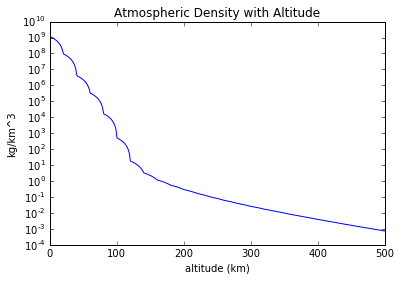

In [6]:
def visualizeDensity():
    xnew = numpy.arange(0, 500000, .1)/1000.
    ynew = density(xnew)
    plt.plot(xnew, ynew)
    plt.xlabel('altitude (km)');plt.ylabel('kg/km^3')
    plt.title('Atmospheric Density with Altitude')
    plt.yscale('log');plt.show()
visualizeDensity()

This is a shitty interpolation, but it's fine for a first pass through this analysis. Rewriting drag in terms of the state variables, we have:

\begin{align}
||\underline{F}_d|| &= \frac{1}{2}C_dA \rho \underline{V}_s^T\underline{V}_s\\
&= \frac{C_d}{2}A({\underline{q}})\rho({\underline{r}})\left(\underline{V}({\underline{r}},{\underline{\dot{r}}})\right)^T\left(\underline{V}({\underline{r}},{\underline{\dot{r}}})\right)
\end{align}

The direction of this force depends somewhat on the attitude of the spacecraft. Many of the incident particles will be scattered randomly, leading to a force opposite the relative velocity of the atmosphere and chip. Some particles, however, will be reflected off the surface, leading to a force opposite the normal to the chip surface.

#### Parameters

Define some parameters relevant to drag. These include the drag coefficient, the spacecraft mass (converted to kg), the surface area (converted to m^2), and the angular velocity of the Earth.

In [4]:
h = .035*1000                                         # spacecraft height, mm
w = .035*1000                                         # spacecraft width, mm
d = .002*1000                                         # spacecraft depth, mm
Az = numpy.array([[h*d, h*d, h*h]]).T                 # z-direction coil surface (m^2)
A = h*h                                               # surface area (mm^2)
Cd = 2.2                                              # drag coefficient
mass = .006                                           # mass of spacecraft, kg
omega_earth = numpy.array([[0., 0., 7.2921159e-5]]).T # angular velocity of Earth, rad/sec

#### Helper Functions

Define some functions for calculating the relative velocity of the atmosphere, the effective surface area of the spacecraft, and the atmospheric density.

In [5]:
def crs(vector):
    first = vector[0][0]
    second = vector[1][0]
    third = vector[2][0]
    return numpy.array([[0., -third, second],
                        [third, 0., -first],
                        [-second, first, 0.]])

def getVs(position, velocity):
    return velocity - numpy.dot(crs(omega_earth), position)

def getDensity(position):
    try:
        return density(numpy.linalg.norm(position) - R_e)
    except:
        print 'Collision with Earth'

#### Drag Function

###### Note: For now the attitude dynamics are still unmodeled. Instead, the effective area is randomized to a number between the thin edge area and the surface area of the chip. The attitude and orbital dynamics are coupled in a later section. It is furthermore assumed that the interaction with the atmosphere is purely diffuse, such that the atmosphere slows the chip in the direction of the relative velocity between the chip and the atmosphere.

Acceleration from drag force, opposite direction of relative velocity with provided (randomized) effective area:

In [6]:
def getDragDecoupled(X):
    position = numpy.array([X[0:3]]).T
    velocity = numpy.array([X[3:6]]).T
    
    Vs = getVs(position, velocity)
    Aeff = X[7]
    rho = getDensity(position)
        
    return 0.5*Aeff*rho*numpy.dot(Vs.T, Vs)[0][0]/mass*(-1*Vs/numpy.linalg.norm(Vs))

### Implementation

#### Gravitational Parameters

Define the necessary paramters for the problem. These include the standard gravitational parameter of the Earth and the J2 constant.

In [7]:
mu_e = 398600.4418   # Earth graviational parameter, (km^3)/(sec^2)
J2   = 1.7555e10     # J2, (km^5)/(sec^2)
R_e  = 6371.         # Radius of Earth, km

#### Derivatives Function

Write a function that takes the state, $\begin{bmatrix}x & y & z & \dot{x} & \dot{y} & \dot{z} & \Delta V\end{bmatrix}$ and returns the time derivative of each state variable, $\begin{bmatrix}\dot{x} & \dot{y} & \dot{z} & \ddot{x} & \ddot{y} & \ddot{z} & \dot{\Delta V}\end{bmatrix}$. $\Delta V$ is not a true state variable, it's included for analysis purposes.

In [8]:
def orbitalDerivatives(X, t):
    x, y, z, xdot, ydot, zdot, dv, A = X
    
    R = (x**2. + y**2. + z**2.)**(1./2.)
    term0 = -mu_e/(R**3.)
    term1 = (5.*J2*(-x**2. - y**2. + 2.*(z**2.)))/(2.*(R**7.))
    term2 = J2/(R**5.)
    
    drag = getDragDecoupled(X)
    dvdot = numpy.linalg.norm(drag)
    
    xddot = term0*x + term1*x + term2*x + drag[0][0]
    yddot = term0*y + term1*y + term2*y + drag[1][0]
    zddot = term0*z + term1*z - term2*z*2. + drag[2][0]
    
    return [xdot, ydot, zdot, xddot, yddot, zddot, dvdot, 0]

#### Simulation Parameters

Define some parameters relevant to the simulation. These include total runtime and stepsize, and initial conditions assuming ISS deployment.

In [9]:
totaltime = numpy.arange(0, 353000, 1)
initial_position = numpy.array([374., 0., 0.])
initial_position = ((initial_position/numpy.linalg.norm(initial_position))*
                     (R_e+numpy.linalg.norm(initial_position)))
initial_velocity = numpy.array([0., 4.76001, 6.01425])
initial_dv = numpy.array([0])
initial_A = numpy.array([(h/1000./1000.)**2.])

#### Run Simulation for Single Set of Initial Conditions

The function below takes a set of initial conditions and propagates them for totaltime (above).

In [10]:
def runOrbitalSim(initial_position, initial_velocity, initial_A, integration_time):
    X = numpy.hstack((initial_position, initial_velocity, initial_dv, initial_A))
    return integrate.odeint(orbitalDerivatives, X, integration_time)

#### Get Angular Velocity from Run Results

I'm experimenting with constructing this problem as a phase-locked loop. Doing so requires that I obtain the angular frequency from the angular velocity. The function below gets the angular frequency for an entire simulation.

In [11]:
def getAngularFrequency(run):
    omega = numpy.zeros((3, len(run[:,0])))
    positions = run[:,0:3].T  # 3xN matrix of positions, first row x, then y, then z
    magnitudes = numpy.linalg.norm(positions, axis=0)**2. # array of magnitudes
    velocities = run[:,3:6].T # 3xN matrix of velocities, first row x, then y, then z
    counter = 0
    for i in range(len(positions[0,:])):
        r = numpy.array([positions[:, counter]]).T
        v = numpy.array([velocities[:, counter]]).T
        magr = magnitudes[counter]
        omega[:, counter] = (numpy.dot(crs(r), v)/magr).T[0]
        counter += 1
    return (numpy.linalg.norm(omega, axis=0)/(2*numpy.pi)) * 1e3 #milliHz

This function gets the angular frequency at a moment in time.

In [12]:
def getAngularFrequencyInstant(run):
    omega = numpy.zeros((3, 1))
    positions = run[-1,0:3].T  # 3xN matrix of positions, first row x, then y, then z
    magnitudes = numpy.linalg.norm(positions, axis=0)**2. # array of magnitudes
    velocities = run[-1,3:6].T # 3xN matrix of velocities, first row x, then y, then z
    r = numpy.array([positions]).T
    v = numpy.array([velocities]).T
    magr = magnitudes
    omega[:, 0] = (numpy.dot(crs(r), v)/magr).T[0]
    return (numpy.linalg.norm(omega, axis=0)/(2*numpy.pi)) * 1e3 #milliHz

#### Visualize Simulation Results

Takes a list of trajectories, plots them with the Earth.

In [13]:
def showResults(results):
    fig = plt.figure()
    ax = plt.gca(projection='3d')
    ax._axis3don = False
    ax.set_aspect('equal')
    
    for run in results:
        ax.plot(run[:,0], run[:,1], run[:,2])
    
    # Draw the Earth
    u, v = numpy.mgrid[0:2*numpy.pi:20j, 0:numpy.pi:10j]
    x=R_e*numpy.cos(u)*numpy.sin(v)
    y=R_e*numpy.sin(u)*numpy.sin(v)
    z=R_e*numpy.cos(v)
    ax.plot_wireframe(x, y, z, color="r", alpha=0.1)
    
    # Configure the plot
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
    # Show the plot
    plt.show()
    
    counter = 0
    for run in results:
        if not counter:
            plt.plot(totaltime/60/60./24, numpy.sqrt(numpy.array(run[:,0])**2. +
                                numpy.array(run[:,1])**2. +
                                numpy.array(run[:,2])**2.) - R_e, label='Max effective area')
            counter+=1
        else:
            plt.plot(totaltime/60/60./24, numpy.sqrt(numpy.array(run[:,0])**2. +
                                numpy.array(run[:,1])**2. +
                                numpy.array(run[:,2])**2.) - R_e, label='Min effective area')
    plt.xlabel('Time (days)')
    plt.ylabel('Altitude (km)')
    plt.title('Orbital Decay from Drag')
    plt.legend(loc='lower left')
    plt.show()
    counter = 0
    for run in results:
        if not counter:
            plt.plot(totaltime/60/60./24, run[:,6]*1000., label='Max effective area')
            counter+=1
        else:
            plt.plot(totaltime/60/60./24, run[:,6]*1000., label='Min effective area')
    plt.xlabel('Time (days)')
    plt.ylabel('Delta-V (m/s)')
    plt.title('Delta-V from Drag')
    plt.legend(loc='lower left')
    plt.yscale('log')
    plt.show()
    
    rho1 = numpy.sqrt(results[0][:,0]**2. + results[0][:,1]**2. + results[0][:,2]**2.)
    f1 = getAngularFrequency(results[0])
    
    if len(results) > 1:
        rho2 = numpy.sqrt(results[1][:,0]**2. + results[1][:,1]**2. + results[1][:,2]**2.)
        f2 = getAngularFrequency(results[1])
    
        plt.plot(totaltime/60/60./24, rho1 - rho2)
        plt.title('Difference in Altitude')
        plt.xlabel('Time (days)')
        plt.ylabel('km')
        plt.show()
        
        plt.plot(totaltime/60/60./24, f1-f2, label='Frequency Error')
        plt.title('Angular Frequency Difference')
        plt.xlabel('Time (days)')
        plt.legend(loc='lower left')
        plt.ylabel('milli Hz')
        plt.show()
    
    plt.plot(totaltime[0:345600]/60/60./24, f1[0:345600], label='Max effective area')
    if len(results) > 1:
        plt.plot(totaltime[0:345600]/60/60./24, f2[0:345600], label='Min effective area')
    plt.title('Angular Frequency')
    plt.xlabel('Time (days)')
    plt.legend(loc='upper left')
    plt.ylabel('milli Hz')
    plt.show()

Run the simulation twice, once for with the maximum effective area exposed to the incident atmosphere, and once with the minimum effective area exposed to the incident atmosphere.

In [14]:
maxarea = runOrbitalSim(initial_position, initial_velocity, initial_A, totaltime)
minarea = runOrbitalSim(initial_position, initial_velocity, numpy.array([(h/1000./1000.)*(d/1000./1000.)]), totaltime)
showResults([maxarea, minarea])

Run the simulation twice again, this time both chips will have the same effective surface area, but one will be given an initial kick.

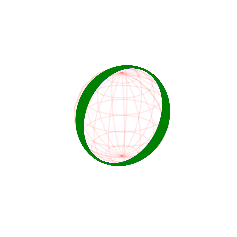

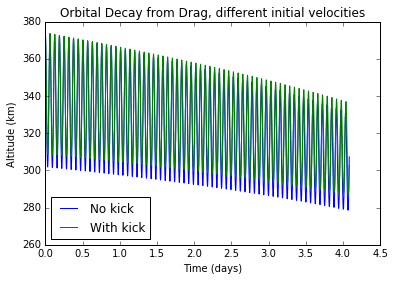

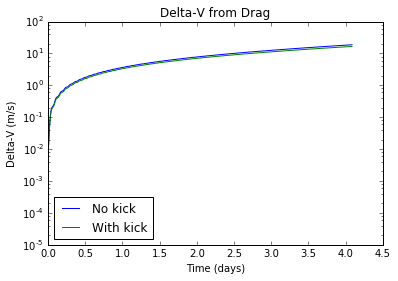

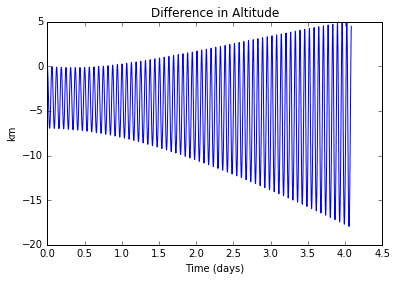

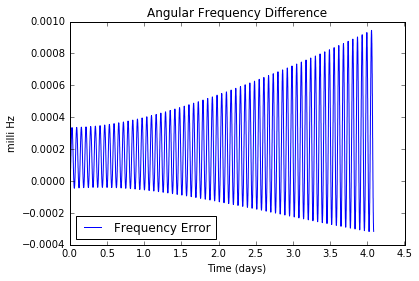

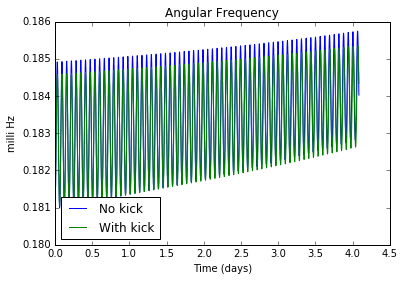

In [15]:
nokick = runOrbitalSim(initial_position, initial_velocity, initial_A/2., totaltime)
withkick = runOrbitalSim(initial_position, initial_velocity +
                           .002*initial_velocity/numpy.linalg.norm(initial_velocity),
                         initial_A/2., totaltime)
showResults([nokick, withkick])

### Controller: Circularization

Based on the above simulations, it is clear that the chipsats have the ability to impart $\Delta$V by changing their effective area to the incident atmosphere. The objective now is to exploit that fact in order to control all chips to return to a common location each orbit. Note that the chips only have the ability to strip themselves of energy, they have no means of gaining additional energy. The strategy is going to be to be to give all chips knowledge of the goal, and then each chip will solve for its own required $\Delta$V and effective area to meet that goal as closely as possible.

Each chip has access to the following information:

1. The trajectory of the target chip
2. Their own initial conditions
3. An onboard dynamics model

#### Target Trajectory 

For now, let us assume that the target chip is one in a circular orbit with a frequency of 0.180 milliHz. Each chip will attempt to get itself onto that orbit.

#### Control Law

If the frequency is too fast, increase surface area. If it's too slow, fly edge-on.

In [15]:
def circularizeOrbit(target=0.1846, finaltime=753000, step=100, control=True):
    pos = initial_position
    vel = initial_velocity
#     vel = numpy.array([0., numpy.sqrt(mu_e/numpy.linalg.norm(pos)), 0.])
    are = initial_A
    
    max_are = numpy.array([(h/1000./1000.)**2.])
    min_are = numpy.array([(h/1000./1000.)*(d/1000./1000)])
    
    freqs = numpy.zeros(len(numpy.arange(0, finaltime, step)))
    alts = numpy.zeros(len(numpy.arange(0, finaltime, step)))
    ares = numpy.zeros(len(numpy.arange(0, finaltime, step)))
    freq_error = numpy.zeros(len(numpy.arange(0, finaltime, step)))
    counter = 0
    max_counter=0
    for t in numpy.arange(0, finaltime, step):
        propagated_state = runOrbitalSim(pos, vel, are, numpy.arange(0, step, 1))
        pos = numpy.array(propagated_state[-1,0:3])
        vel = numpy.array(propagated_state[-1,3:6])
        
        frequency = getAngularFrequencyInstant(propagated_state)[0]
        freqs[counter] = frequency
        freq_error[counter] = frequency - target
        alts[counter] = numpy.linalg.norm(pos)-R_e
        
        if control:
            if max_counter < 40:
                if frequency > target:
                    are = max_are
                    max_counter+=1
                else:
                    max_counter=0
                    are = min_are
            else:
                are = min_are
        else:
            are = initial_A/5.
        ares[counter] = numpy.linalg.norm(are)
        counter += 1
    return freqs, alts, ares, freq_error

Write a function to verify that the controlled chip circularizes better than the uncontrolled chip (sanity check):

In [16]:
def testController():
    test = circularizeOrbit()
    test1 = circularizeOrbit(control=False)
    plt.plot(numpy.arange(0, 753000, 100)/60/60/24.,test1[0], label='uncontrolled', alpha=0.5)
    plt.plot(numpy.arange(0, 753000, 100)/60/60/24.,test[0], label='controlled');
    plt.xlabel('Days')
    plt.title('Frequency (mHz)');
    plt.legend(loc='best')
    plt.show()
    plt.plot(numpy.arange(0, 753000, 100)/60/60/24.,test1[1], label='uncontrolled', alpha=0.5)
    plt.plot(numpy.arange(0, 753000, 100)/60/60/24.,test[1], label='controlled');
    plt.xlabel('Days')
    plt.title('Altitude (km)');
    plt.legend(loc='best')
    plt.show()
    plt.plot(numpy.arange(0, 753000, 100)/60/60/24.,test1[2], label='uncontrolled', alpha=0.5)
    plt.plot(numpy.arange(0, 753000, 100)/60/60/24.,test[2], label='controlled');
    plt.xlabel('Days')
    plt.title('Control area');
    plt.legend(loc='best')
    plt.show()
    plt.plot(numpy.arange(0, 753000, 100)/60/60/24.,test1[3], label='uncontrolled', alpha=0.5)
    plt.plot(numpy.arange(0, 753000, 100)/60/60/24.,test[3], label='controlled');
    plt.xlabel('Days')
    plt.title('Frequency Error (mHz)');
    plt.legend(loc='best')
    plt.show()
testController()

Write a function to verify targeting of different frequencies (altitudes):

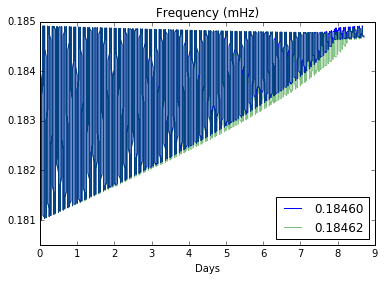

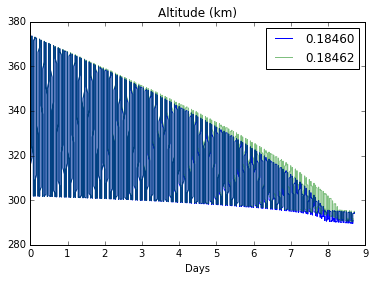

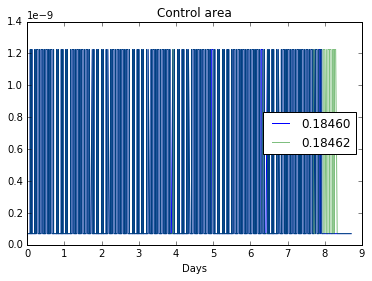

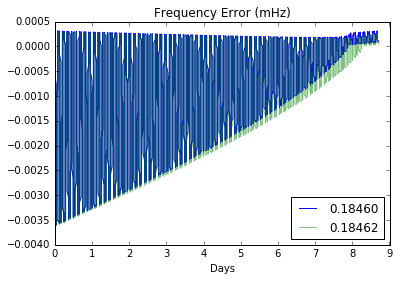

In [72]:
def testControllerFreqTarget():
    test = circularizeOrbit(target=0.18462)
    test1 = circularizeOrbit(target=0.18460)
    plt.plot(numpy.arange(0, 753000, 100)/60/60/24.,test1[0], label='0.18460')
    plt.plot(numpy.arange(0, 753000, 100)/60/60/24.,test[0], label='0.18462',alpha=0.5);
    plt.xlabel('Days')
    plt.title('Frequency (mHz)');
    plt.legend(loc='best')
    plt.show()
    plt.plot(numpy.arange(0, 753000, 100)/60/60/24.,test1[1], label='0.18460')
    plt.plot(numpy.arange(0, 753000, 100)/60/60/24.,test[1], label='0.18462',alpha=0.5);
    plt.xlabel('Days')
    plt.title('Altitude (km)');
    plt.legend(loc='best')
    plt.show()
    plt.plot(numpy.arange(0, 753000, 100)/60/60/24.,test1[2], label='0.18460')
    plt.plot(numpy.arange(0, 753000, 100)/60/60/24.,test[2], label='0.18462',alpha=0.5);
    plt.xlabel('Days')
    plt.title('Control area');
    plt.legend(loc='best')
    plt.show()
    plt.plot(numpy.arange(0, 753000, 100)/60/60/24.,test1[3], label='0.18460')
    plt.plot(numpy.arange(0, 753000, 100)/60/60/24.,test[3], label='0.18462',alpha=0.5);
    plt.xlabel('Days')
    plt.title('Frequency Error (mHz)');
    plt.legend(loc='best')
    plt.show()
testControllerFreqTarget()

## Constructing the Constellations

Based on the above tests, we've shown that the idealized chips have the ability to circularize their orbits to within approximately 10 km. I will come back to improve this controller, but I'm moving along for now to avoid becoming buried in the weeds. Before moving on, we must determine how to best construct the interacting constellations of satellite rings. How many satellites should be in each ring in order to maximize the frequency of their interactions, and how do these interactions change with altitude?

Consider a circular orbit. The velocity of an object in circular orbit is given by:

\begin{align}
v &= \sqrt{\frac{\mu}{R}}
\end{align}

The total distance that the spacecraft must travel in order to complete an orbit is given by:

\begin{align}
D &= 2\pi R
\end{align}

From these, we obtain the orbital period:

\begin{align}
T &= \frac{D}{v}\\
&= \frac{2\pi}{\sqrt{\mu}}R^{\frac{3}{2}}
\end{align}

The angular velocity can be obtained directly from the orbital period:

\begin{align}
\omega &= \frac{2\pi}{T}\\
&= \frac{\sqrt{\mu}}{r^{\frac{3}{2}}}
\end{align}

We now consider two co-planar circular constellations of spacecraft at different altitudes, $R_{1}$ and $R_2$. Constellation 1 (the inner constellation) has $N_1$ evenly spaced spacecraft, and constellation 2 has $N_2$ evenly spaced spacecraft. Using the above equations, we can find the relative angular velocity among the two constellations.

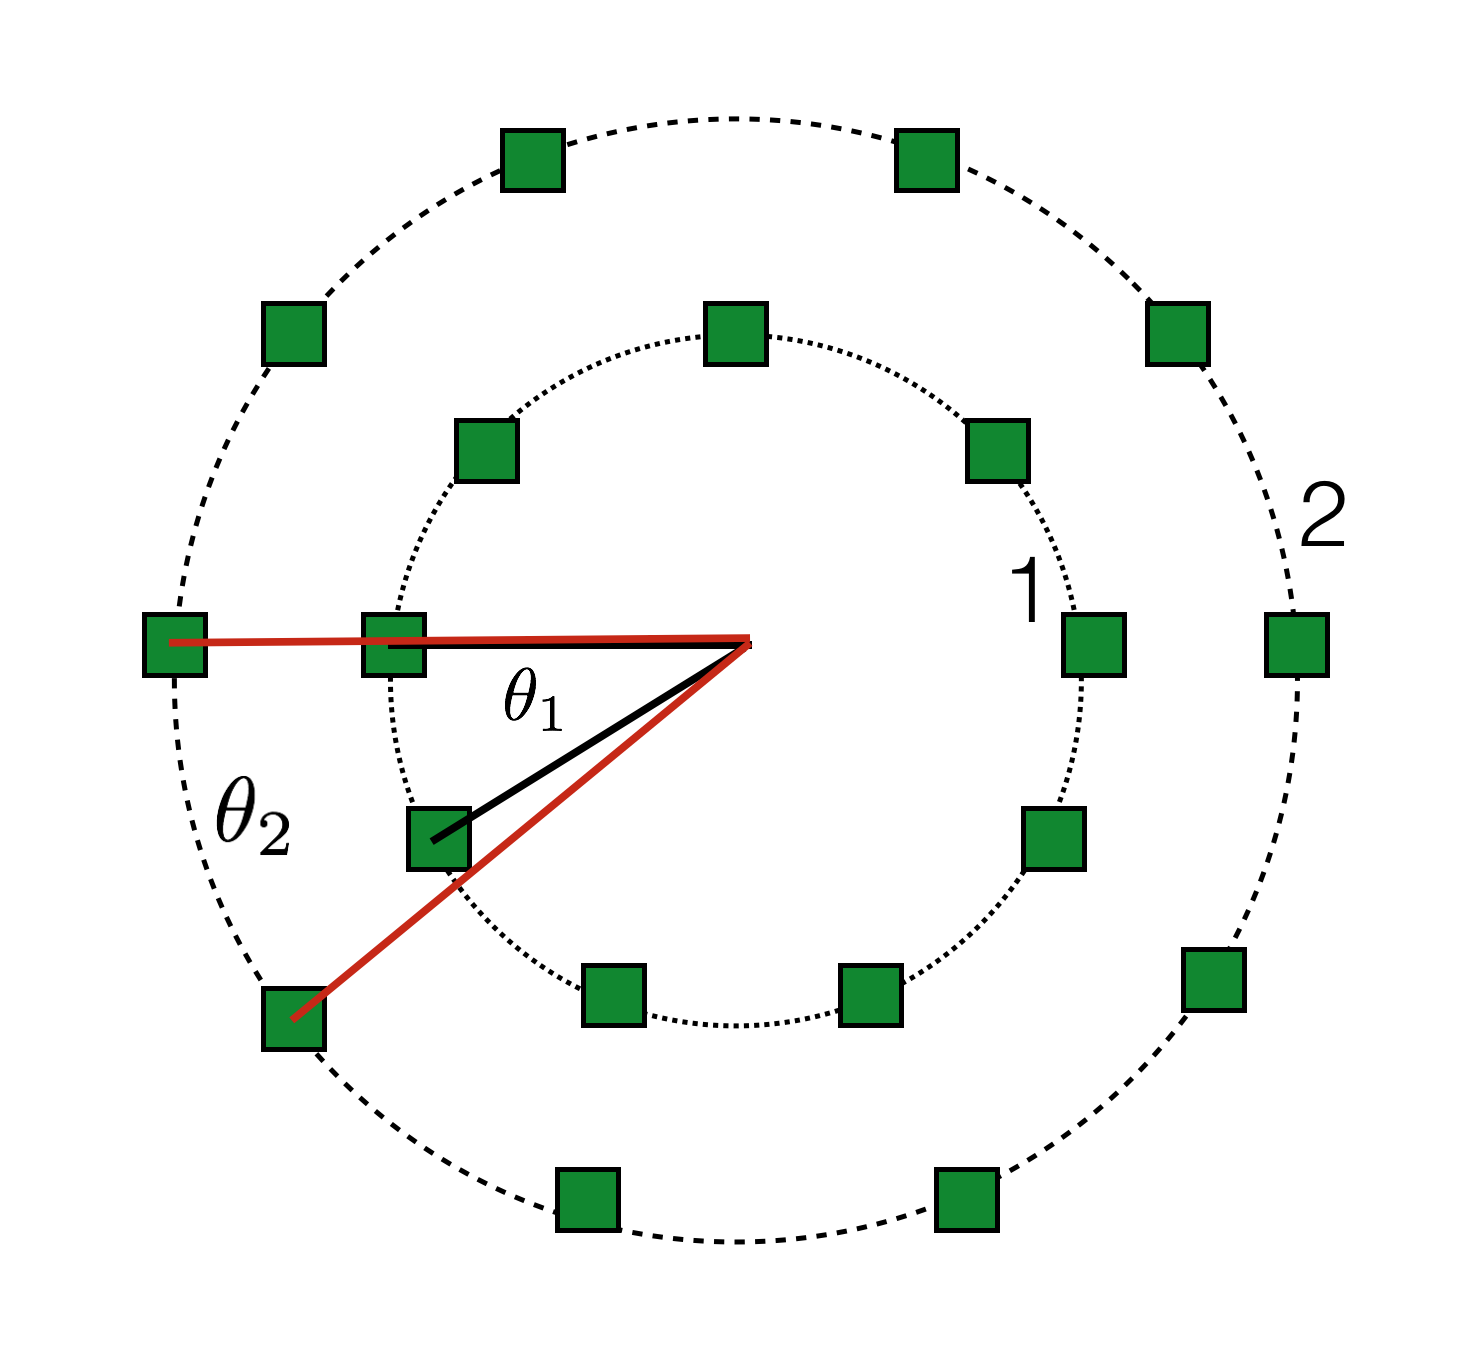

In [58]:
Image(filename = PATH + "constellation.png", width=400, height=400)

The relative angular velocity is given by:

\begin{align}
\omega^{1/2} &= \omega^1 - \omega^2\\
&= \sqrt{\mu}\left[\frac{1}{R_1^{\frac{3}{2}}} - \frac{1}{R_2^{\frac{3}{2}}}\right]
\end{align}

By considering the problem in terms of the above relative angular velocity, we can treat constellation 2 as fixed while constellation 1 spins within it. From the relative angular velocity, we find the relative period of the two constellations:

\begin{align}
T^{1/2} &= \frac{2\pi}{\omega^{1/2}}\\
&= \frac{2\pi}{\sqrt{\mu}}\left[\frac{1}{R_1^{\frac{3}{2}}} - \frac{1}{R_2^{\frac{3}{2}}}\right]^{-1}
\end{align}

Once a chip in constellation 1 aligns with a chip in constellation 2, how long will it take for the chip to align with the next spacecraft in constellation 2?

\begin{align}
\tilde{T}_1 &= \frac{2\pi}{N_2\sqrt{\mu}}\left[\frac{1}{R_1^{\frac{3}{2}}} - \frac{1}{R_2^{\frac{3}{2}}}\right]^{-1}
\end{align}

So, assuming alignment at $t_{0}$, I can solve for all future alignments of this particular chip:

\begin{align}
\{t_1\} &= \tilde{T}_1N \\&= \frac{2\pi}{N_2\sqrt{\mu}}\left[\frac{1}{R_1^{\frac{3}{2}}} - \frac{1}{R_2^{\frac{3}{2}}}\right]^{-1}N
\end{align}

For all other chips in constellation 1, the alignment times will be $\{t_1\}$ plus the amount of time that it takes to achieve the first alignment. Note that alignment can only occur by catching up to the leading chip in constellation 2. This times will depend on our choices for $N_1$ and $N_2$, the number of spacecraft in each constellation. We want to choose these values such that the frequency of alignment events is maximized. In other words, we do not want more than two chips aligning at a single time, since we would prefer more alignment events at unique times.

Let us assume that a chip in constellation 1 and a chip in constellation 2 are aligned. We can solve for the necessary conditions for any other pair of chips to also be aligned (something we'd like to avoid). Another set of chips will be aligned if and only if:

\begin{align}
M\theta_1 = K\theta_2
\end{align}

Where $M$ and $K$ are integers. Substituting:

\begin{align}
\frac{2\pi M}{N_1} &= \frac{2\pi K}{N_2}\\
\frac{M}{N_1} &= \frac{K}{N_2}\\
\frac{N_1}{M} &= \frac{N_2}{K} = \text{integer}
\end{align}

The above requires that $N_1$ and $N_2$ share a common factor. Thus, if $N_1$ and $N_2$ are non-prime, multiple chips will align at a single time during one period of constellation 1 within constellation 2. For a single period of constellation 1, therefore, we will have $<N_1N_2$ alignment events, since some of those events will involve alignments among multiple pairs of chips. If, however, we choose $N_1$ and $N_2$ to be co-prime (no common factor other than 1), then we guarantee that only two chips at a time will ever be in alignment. This ensures that, for a single period of constellation 1, there are $N_1N_2$ alignment events.

Another way to consider this issue is in terms of periodicity. For certain choices of $N_{1}$ and $N_{2}$, the system is periodic for angular displacements of constellation 1 by less than $2\pi$. An obvious example is to consider $N_{1}=2N_{2}$. In such a case, the system looks identical each time constellation 1 rotates by $\theta_2$. In order to maximize the number of unique alignment events, we want to maximize the period of the system. The maximum possible period for the relative constellations is $2\pi$ (since the system will obviously look the same after one full rotation of constellation 1). We can enforce this condition by enforcing that the lowest common multiple of $\theta_1$ and $\theta_2$ by $2\pi$.

\begin{align}
\text{lcm}(\theta_1,\theta_2) &= 2\pi\\
&\rightarrow \text{lcm}(\frac{2\pi}{N_1},\frac{2\pi}{N_2}) = 2\pi\\
&\rightarrow \text{lcm}(\frac{1}{N_1},\frac{1}{N_2}) = 1\\
&\rightarrow \text{lcm}(\frac{N_2}{N_1N_2},\frac{N_1}{N_1N_2}) = 1\\
&\rightarrow \text{lcm}(N_1,N_2) = N_1N_2\\
&\rightarrow \text{$N_1$ and $N_2$ are co-prime numbers}
\end{align}

To maximize the period of the system, we require that the number of spacecraft in each constellation be co-prime. We are now in a position to find an expression for the time of every alignment event in terms of the altitudes of the orbits and the numbers of chips in each constellation.

The time between alignments for each chip is given above. The expression for the time to initial alignment is given by:

\begin{align}
t_{i} = \frac{\left[\frac{2\pi}{N_2} - \left(\frac{2\pi M}{N_1}\% \frac{2\pi}{N_2}\right)\right]}{\sqrt{\mu}\left[\frac{1}{R_1^{\frac{3}{2}}} - \frac{1}{R_2^{\frac{3}{2}}}\right]}\text{ For $M=0$,$\dots$,$N_1-1$}
\end{align}

The times of alignment are then given by:

\begin{align}
T_i &= t_i + \frac{2\pi}{N_2\sqrt{\mu}}\left[\frac{1}{R_1^{\frac{3}{2}}} - \frac{1}{R_2^{\frac{3}{2}}}\right]^{-1}N\\
&\text{For $N=0,\dots,\infty$}
\end{align}

Write a function that takes $N_1$, $N_2$, $R_1$, and $R_2$. The function should return the time for one relative rotation of constellation 1, the times of alignment, the times between alignment.

In [17]:
def getAlignments(N1, N2, R1, R2):
    ti = numpy.zeros(N1)
    times = numpy.zeros(N1*N2)
    for i in range(N1):
        numerator = (((2*numpy.pi)/N2) - ((2*numpy.pi*i)/N1) % ((2*numpy.pi)/N2))
        denominator = numpy.sqrt(mu_e)*((1/(R1**(3./2.))) - (1/(R2**(3./2.))))
        ti[i] = numerator/denominator
    dex = 0
    for i in range(N2):
        times[dex:dex+N1] = ti + (((2*numpy.pi)/(N2*numpy.sqrt(mu_e)))*
                                  (((1/(R1**(3./2.))) - (1/(R2**(3./2.))))**(-1.)))*i
        dex += N1
    times = sorted(times)
    return times, times[1]-times[0]

#### Period of Alignment with Altitude and Chip Number

Plot the period of alignment events as a function of number of chips. Assume that the two constellations are separated by one kilometer, and that the altitude of each constellation is held fixed. The number of chips in each constellation should be co-prime (consecutive integers work).

In [18]:
def quantityTest():
    R2 = 500
    R1 = R2 - 1.
    periods = numpy.zeros((200,100))
    alts = numpy.arange(R2 - 200, R2, 1)
    alts = sorted(alts, reverse=True)
    for i in numpy.arange(0, 200, 1):
        N1 = 2
        N2 = N1 - 1
        nums = numpy.arange(1, 101, 1)
        for j in numpy.arange(0, 100, 1):
            periods[i,j] = getAlignments(N1, N2, R1, R2)[1]
            N1+=1
            N2+=1
        if i==0:
            plt.plot(nums,periods[i,:], 'r', lw=2, label='500 km')
        elif i==199:
            plt.plot(nums,periods[i,:], 'b', lw=2, label='300 km')
        else:
            plt.plot(nums,periods[i,:], alpha=0.05)
        R2 = R2 - 1
        R1 = R1 - 1
    plt.xlabel('Number of Spacecraft in Inner Constellation')
    plt.ylabel('Seconds')
    plt.title('Alignment Period with Altitude and Number of Chips')
    plt.yscale('log')
    plt.legend(loc='upper right')
    plt.show()
    return periods
quantityTest();

#### Conclusions to be Drawn

There are diminishing returns associated with adding more chips to the constellations. For a given altitude, the difference in alignment period for 30 and 50 chips is a few seconds. Furthermore, relatively few chips are required in order to have an edge connection every minute or less. This assumes, of course, that the chips are evenly distributed throughout the circular orbit.

## Routing Information

## Achieving Formation

We've shown that the chips can achieve a target circular orbit by measuring and adjusting their orbital frequency, and we've shown that the optimal formation for maximizing alignment frequency is evenly spaced ring constellations of co-prime numbers of spacecraft. The objective now is to come up with a deployment/control scheme that gets the chips into this formation.

## Attitude Dynamics

### Theory

#### General Expression

We wish to find the equation of motion for a spacecraft tumbling through space. In order to do this, we can take the time derivative of the angular momentum vector.

\begin{align}
{}^{B}{\bf{H}} = {}^{B}\begin{bmatrix}H_{x} & H_{y} & H_{z}\end{bmatrix} \cdot ^{B}\begin{bmatrix}
{\bf{\hat{i}}}_{B}&
{\bf{\hat{j}}}_{B}&
{\bf{\hat{k}}}_{B}
\end{bmatrix}^{T}
\end{align}

Taking the time-derivative in an inertial frame:

\begin{align}
\overset{N}{{\bf{H}}} &= {}^{B}\begin{bmatrix}\dot{H}_{x} & \dot{H}_{y} & \dot{H}_{z}\end{bmatrix} \cdot ^{B}\begin{bmatrix}
{\bf{\hat{i}}}_{B}&
{\bf{\hat{j}}}_{B}&
{\bf{\hat{k}}}_{B}
\end{bmatrix}^{T} + 
{}^{B}\begin{bmatrix}H_{x} & H_{y} & H_{z}\end{bmatrix} \cdot ^{B}\begin{bmatrix}
{\bf{\dot{\hat{i}}}}_{B}&
{\bf{\dot{\hat{j}}}}_{B}&
{\bf{\dot{\hat{k}}}}_{B}
\end{bmatrix}^{T} = 0 \text{ (no external torques)}\\
&= \overset{B}{{\bf{H}}} + ({\bf{\omega}}^{B/N} \times {}^{B}{\bf{H}})
\end{align}

#### Chipsat and Kane Damper Angular Momenta

Write down the angular momentum vector:

\begin{align}
{\bf{H}}_{tot} = {\bf{h}}_{spacecraft} + h_{antennae}
\end{align}

The antennae dissipate energy, ultimately leading to a flatspin about chipsat maximum axis. For now, I will model them as approximately Kane Dampers.

\begin{align}
{\bf{h}}_{spacecraft} &= I_{B}\cdot {\bf{\omega}}^{B/N}\\
{\bf{h}}_{damper} &= I_{D} \cdot {\bf{\omega}}^{D/N}\\
&= I_{D}\cdot \left({\bf{\omega}}^{D/B} + {\bf{\omega}}^{B/N}\right)
\end{align}

#### Time Derivatives

In this case, the only source of torque is from the torque coils. This leads to the differential equation:

\begin{align}
\overset{N}{\bf{h}}_{spacecraft} &= I_{B} \cdot \dot{\omega}^{B/N} + \omega^{B/N} \times \left[I_{B} \cdot \omega^{B/N}\right] = \tau_{D} + \tau_{coils} = c\omega^{D/B}+\tau_{coils}\\
\overset{N}{\bf{h}}_{damper} &= I_{D} \cdot \dot{\omega}^{D/N} + \omega^{B/N} \times \left[I_{D} \cdot \omega^{D/N}\right] = -\tau_{D} = -c\omega^{D/B}\\
&= I_{D} \cdot \left(\dot{\omega}^{D/B} + \dot{\omega}^{B/N}\right) + \omega^{B/N} \times \left[ I_{D} \cdot \left(\omega^{D/B} + \omega^{B/N}\right)\right] + c\omega^{D/B}
\end{align}

Solving each of the above equations:

\begin{align}
\dot{\omega}^{B/N} &= -I_{B}^{-1}\left[\omega^{B/N} \times \left[I_{B} \cdot \omega^{B/N}\right] - c\omega^{D/B} + \tau_{coil}\right]\\
\dot{\omega}^{D/B} &= -I_{D}^{-1}\left[I_{D} \cdot \dot{\omega}^{B/N} + \omega^{B/N} \times \left[ I_{D} \cdot \left(\omega^{D/B} + \omega^{B/N}\right)\right] + c\omega^{D/B}\right]\\
&= -I_{D}^{-1}\left[I_{D} \cdot \left(-I_{B}^{-1}\left[\omega^{B/N} \times \left[I_{B} \cdot \omega^{B/N}\right] - c\omega^{D/B} + \tau_{coil}\right]\right) + \omega^{B/N} \times \left[ I_{D} \cdot \left(\omega^{D/B} + \omega^{B/N}\right)\right] + c\omega^{D/B}\right]
\end{align}

where:

\begin{align}
\tau_{coils} &= \sum_{i=1}^{3}\tau_{i}\\
&= \sum_{i=1}^{3}{\bf{\mu}}_{i} \times {\bf{B}}\\
&= N\sum_{i=1}^{3}i_{i}\left({\bf{A}}_{i}\times{\bf{B}}\right)\\
&= N i_{z}\left({\bf{A}}_{z}\times{\bf{B}}\right)
\end{align}

In the above expression, $N$ is the number of loops for each torque coil, $i$ is the current in the loop, ${\bf{A}}$ is the coil area, and ${\bf{B}}$ is the magnetic field vector. Rewriting:

\begin{align}
\dot{\omega}^{B/N} &= -I_{B}^{-1}\left[\omega^{B/N} \times \left[I_{B} \cdot \omega^{B/N}\right] - c\omega^{D/B} + N i_{z}\left({\bf{A}}_{z}\times{\bf{B}}\right)\right]\\
\dot{\omega}^{D/B} &= -I_{D}^{-1}\left[I_{D} \cdot \dot{\omega}^{B/N} + \omega^{B/N} \times \left[ I_{D} \cdot \left(\omega^{D/B} + \omega^{B/N}\right)\right] + c\omega^{D/B}\right]\\
&= -I_{D}^{-1}\left[I_{D} \cdot \left(-I_{B}^{-1}\left[\omega^{B/N} \times \left[I_{B} \cdot \omega^{B/N}\right] - c\omega^{D/B} + N i_{z}\left({\bf{A}}_{z}\times{\bf{B}}\right)\right]\right) + \omega^{B/N} \times \left[ I_{D} \cdot \left(\omega^{D/B} + \omega^{B/N}\right)\right] + c\omega^{D/B}\right]
\end{align}

#### The Magnetic Field

For now, let us assume that the magnetic field is fixed in the inertial frame, and any perceived change in the direction of that field is due to spacecraft rotation. This assumption can be expressed as:

\begin{align}
{}^{B}{{\bf{B}}} &= A(q){}^{N}{\bf{B}}\\
&= \begin{bmatrix}
1 - 2q_2^2 - 2q_3^2 & 2q_1q_2 - 2q_3q_4 & 2q_1q_3 + 2q_2q_4\\
2q_1q_2 + 2q_3q_4 & 1 - 2q_1^2 - 2q_3^2 & 2q_2q_3 - 2q_1q_4\\
2q_1q_3 - 2q_2q_4 & 2q_1q_4 + 2q_2q_3 & 1 - 2q_1^2 - 2q_2^2
\end{bmatrix}{}^{N}{\bf{B}}
\end{align}

where ${}^{B}{\bf{B}}$ is the magnetic field vector in the spacecraft body frame - measured by the magnetometer. $A(q)$ is the rotation matrix formed from the spacecraft quaternion, and $q_{1,2,3,4}$ are the components of the quaternion. The rate of change of the magnetic field in the spacecraft body frame is given by:

\begin{align}
\overset{N}{{\bf{B}}} &= \overset{B}{{\bf{B}}} + \omega^{B/N} \times {}^{B}{\bf{B}} = 0 \hspace{5mm} \text{(Assuming fixed inertial magnetic field)}\\
&\rightarrow \overset{B}{\bf{B}} = -\omega^{B/N}\times{}^{B}{\bf{B}}
\end{align}

#### Quaternion

The rate of change of the quaternion is also expressed as a differential equation related to the angular velocity of the spacecraft.

\begin{align}
\dot{q} &= \frac{1}{2} \omega \otimes q\\
&= \frac{1}{2}\begin{bmatrix}
0 & \omega_{z} & -\omega_y & \omega_x\\
-\omega_z & 0 & \omega_x & \omega_y\\
\omega_y & -\omega_x & 0 & \omega_z\\
-\omega_x & -\omega_y & -\omega_z & 0
\end{bmatrix}\begin{bmatrix}
q_1 \\ q_2 \\ q_3 \\ q_4\end{bmatrix}
\end{align}

The result is a set of coupled differential equations. To solve for the motion of the spacecraft and the motion of the magnetic field in the spacecraft's frame, we numerically integrate the coupled equations. In this case, the state is $\begin{bmatrix}q_1 & q_2 & q_3 & q_4 & \omega_x & \omega_y & \omega_z & \omega^D_x & \omega^D_y & \omega^D_z & i_z\end{bmatrix}$.

### Implementation

#### Parameters

Define some parameters relevant to the rotational dynamics of the chipsat.

In [33]:
m =  mass*1000                                             #spacecraft mass, g
Ib = numpy.array([[(1./12.)*m*(h**2. + d**2.), 0., 0.],
                  [0., (1./12.)*m*(w**2. + d**2.), 0.],
                  [0., 0., (1./12.)*m*(w**2. + h**2.)]])   #spacecraft inertia tensor
N=12.                                                      #number of loops in each coil
B = numpy.array([[0., 0., 20e-6]]).T*1000                  #inertial magnetic field, (gram-Teslas)
mdamp = .003*1000                                          #damper mass, g
mrad = .03*1000                                            #damper radius, mm
c = 10.                                                    #damping coefficient
Id = numpy.array([[(2./5.)*mdamp*mrad**2., 0., 0.],
                  [0., (2./5.)*mdamp*mrad**2., 0.],
                  [0., 0., (2./5.)*mdamp*mrad**2.]])       #damper inertia tensor

#### Helper Functions

Some helper functions. The first forms the cross product matrix, the second forms the skew-symmetric cross product matrix for the angular velocity, and the third forms a direction cosine matrix from a quaternion.

In [34]:
def quatcrs(omega):
    wx, wy, wz = omega[0][0], omega[1][0], omega[2][0]
    return numpy.array([[0., wz, -wy, wx],
                        [-wz, 0., wx, wy],
                        [wy, -wx, 0., wz],
                        [-wx, -wy, -wz, 0.]])

def formA(q):
    q1, q2, q3, q4 = q[0][0], q[1][0], q[2][0], q[3][0]
    return numpy.array([[1. - 2.*q2**2. - 2.*q3**2., 2.*q1*q2 - 2.*q3*q4, 2.*q1*q3 + 2.*q2*q4],
                        [2.*q1*q2 + 2.*q3*q4, 1.-2.*q1**2. - 2.*q3**2., 2.*q2*q3 - 2.*q1*q4],
                        [2.*q1*q3 - 2.*q2*q4, 2.*q1*q4 + 2.*q2*q3, 1.-2.*q1**2. - 2.*q2**2.]])

#### Derivative Function

The function below takes the state as an input, and returns the derivative of each state variable.

In [35]:
def rotationalDerivative(X, t):
    #unpack
    q1, q2, q3, q4, omegax, omegay, omegaz, omegadx, omegady, omegadz, iz = X
    
    #create vectors
    quaternion = numpy.array([[q1, q2, q3, q4]]).T
    omega = numpy.array([[omegax, omegay, omegaz]]).T
    omegad = numpy.array([[omegadx, omegady, omegadz]]).T
    
    #find magnetic field
    Bvec = numpy.dot(formA(quaternion), B)#---------------------------------------magnetic field, body frame
    
    #spacecraft derivative
    control = N*iz*numpy.dot(crs(Az), Bvec)#--------------------------------------control term
    damp = c*omegad#--------------------------------------------------------------damper term
    first_term = numpy.dot(crs(omega), numpy.dot(Ib, omega))#---------------------first term in parentheses
    omega_dot = numpy.dot(-1.*pinv(Ib), first_term - damp + control)#-------------spacecraft body time derivative
    
    #damper derivative
    first_term_d = numpy.dot(Id, omega_dot)#--------------------------------------first term in parentheses
    second_term_d = numpy.dot(crs(omega), numpy.dot(Id, omegad+omega))#-----------second term in parentheses
    omegad_dot = numpy.dot(-1.*pinv(Id), first_term_d + second_term_d + damp)#----damper time derivative
    
    #quaternion derivative
    q_dot = .5*numpy.dot(quatcrs(omega), quaternion)#-----------------------------quaternion time derivative
    
    #control input derivative
    izdot = numpy.array([0])#-----------------------------------------------------control derivative
    
    #return derivatives
    derivs = numpy.hstack((q_dot.T[0], omega_dot.T[0], omegad_dot.T[0], izdot))#--derivatives
    return derivs

#### Simulation Parameters

Define parameters relevant to the simulation

In [36]:
attitudetime = numpy.arange(0, 500, 1)
initial_quaternion = numpy.array([0., 0., 0., 1.])
# initial_quaternion = numpy.array([0.7071067811865476, 0., 0.7071067811865476, 0.])
initial_quaternion = initial_quaternion/numpy.linalg.norm(initial_quaternion)
initial_omega = numpy.array([0., 1., 1.])
initial_omegad = numpy.array([0., 0., 0.])
initial_iz = numpy.array([0.])

#### Run Simulation for Single Set of Initial Conditions

In [37]:
def runAttitudeSim(initial_quaternion, initial_omega, initial_omegad, initial_iz):
    X = numpy.hstack((initial_quaternion, initial_omega, initial_omegad, initial_iz))
    return integrate.odeint(rotationalDerivative, X, attitudetime)

#### Visualize Simulation Results

The function below takes a list of attitude simulation results and plots them.

In [38]:
def showAttitudeResults(results):
    for run in results:
        plt.title('Quaternion')
        plt.xlabel('Time (sec)')
        plt.plot(attitudetime,run[:,0], label='$q_1$')
        plt.plot(attitudetime,run[:,1], label='$q_2$')
        plt.plot(attitudetime,run[:,2], label='$q_3$')
        plt.plot(attitudetime,run[:,3], label='$q_4$')
        plt.ylim([-1.1,1.1])
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
    for run in results:
        plt.title('Spacecraft Angular Velocity')
        plt.xlabel('Time (sec)')
        plt.ylabel('Rad/Sec')
        plt.plot(attitudetime,run[:,4], label='$\omega_x^{B/N}$')
        plt.plot(attitudetime,run[:,5], label='$\omega_y^{B/N}$')
        plt.plot(attitudetime,run[:,6], label='$\omega_z^{B/N}$')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
    for run in results:
        plt.title('Damper Relative Angular Velocity')
        plt.xlabel('Time (sec)')
        plt.ylabel('Rad/Sec')
        plt.plot(attitudetime,run[:,7], label='$\omega_x^{D/B}$')
        plt.plot(attitudetime,run[:,8], label='$\omega_y^{D/B}$')
        plt.plot(attitudetime,run[:,9], label='$\omega_z^{D/B}$')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()

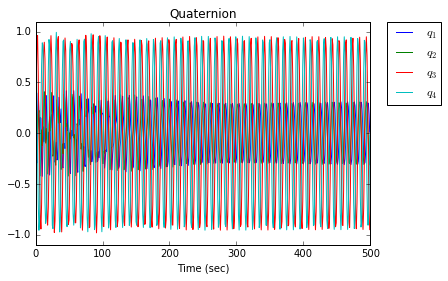

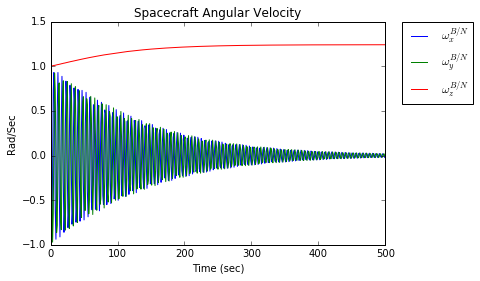

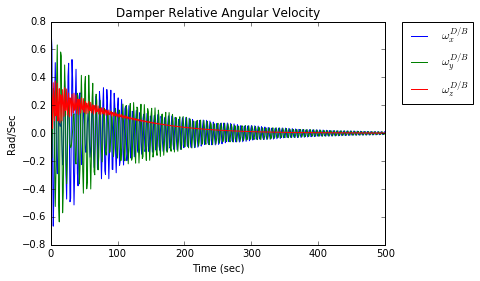

In [39]:
showAttitudeResults([runAttitudeSim(initial_quaternion, initial_omega,
                                    initial_omegad, initial_iz)])

## The Coupled System

In [8]:
def getAECI(quaternion):
    return numpy.dot(formA(quaternion), area)

def getAeff(Vs, AECI):
    return abs(numpy.dot(AECI.T, Vs/numpy.linalg.norm(Vs))[0][0])

In [112]:
def getDrag(X):
    position = numpy.array([X[0:3]]).T
    velocity = numpy.array([X[3:6]]).T
    quaternion = numpy.array([X[6:10]]).T
    omega = numpy.array([X[10:13]]).T
    omega_d = numpy.array([X[13:16]]).T
    iz = numpy.array([X[17]])
    
    Vs = getVs(position, velocity)
    AECI = getAECI(quaternion)
    Aeff = getAeff(Vs, AECI)
    Aeff = a random number
    rho = getDensity(position)
        
    return 0.5*Aeff*rho*numpy.dot(Vs.T, Vs)[0][0]*(-1*Vs/numpy.linalg.norm(Vs))